In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
sns.set_style('white')

In [83]:
def sweep_steps(amplitudes=np.arange(10), n_trials=10, dt_sec=0.001, stim_length_sec=0.1, sig=.1, debug_plot=True):
    """
    Return amplitude of input current across time, with as many input signals as the dimension of
    the input amplitudes.

    dt_sec:
    stim_length_sec:
    amplitudes
    
    input_curent: batch_size (1) x time bins x neurons (or n amplitudes x n trials)
    """
    n_time_bins = int(np.floor(stim_length_sec / dt_sec))
    n_neurons = len(amplitudes) * n_trials
    stim = []
    list_mean_current = []  # list with mean current value (same dimension as the last dimension of input_current)
    for a in amplitudes:
        for n in range(n_trials):
            # stim.append(torch.tensor([a] * n_time_bins))
            I_gwn = a + sig * np.random.randn(n_time_bins) / np.sqrt(n_time_bins / 1000.)
            stim.append(torch.tensor(I_gwn))
            list_mean_current.append(a)

    input_current = torch.stack(stim, dim=1)
    input_current = torch.reshape(input_current, (n_time_bins, n_neurons))
    input_current = input_current[None, :]  # add first dimension for batch size 1

    assert input_current.shape[0] == 1
    assert input_current.shape[1] == n_time_bins
    assert input_current.shape[2] == len(
        amplitudes) * n_trials  # thid dim: n_trials = n_neurons (all stimulated ad once)
    
    if debug_plot:
        for i in range(input_current.shape[2]):
            plt.plot(np.arange(n_time_bins)*dt_sec, input_current[0, :, i])
        plt.xlabel('Time (sec)')
        plt.ylabel('Input current')

    return input_current, list_mean_current


def sweep_amplitude_oscillations(amplitudes=np.arange(10), n_trials=10, offset=0, f=10, fs=1000, target_snr_db=20, debug_plot=True, add_noise=True):
    """
    Return amplitude of input current across time, with as many input signals as the dimension of
    the input amplitudes.

    dt_sec:
    stim_length_sec:
    amplitudes
    """
    t = np.arange(fs) / fs
    print(f'n time bins:{len(t)}')
    print(f'Period T:{1 / f} sec')

    n_time_bins = len(t)
    n_neurons = len(amplitudes) * n_trials
    stim = []
    list_mean_current = []  # list with mean current value (same dimension as the last dimension of input_current)
    for a in amplitudes:
        for n in range(n_trials):
            x = a * np.sin(2 * np.pi * f * t) + offset
            x_watts = x ** 2

            sig_avg_watts = np.mean(x_watts)
            sig_avg_db = 10 * np.log10(sig_avg_watts)
            # Calculate noise according to [2] then convert to watts
            noise_avg_db = sig_avg_db - target_snr_db
            noise_avg_watts = 10 ** (noise_avg_db / 10)
            # Generate an sample of white noise with mean zero. For white noise, Ex and the average power is then equal to the variance Ex.
            mean_noise = 0
            noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
            # Noise up the original signal
            I = x + noise_volts*add_noise

            stim.append(torch.tensor(I))
            list_mean_current.append(a)

    input_current = torch.stack(stim, dim=1)
    input_current = torch.reshape(input_current, (n_time_bins, n_neurons))
    input_current = input_current[None, :]  # add first dimension for batch size 1

    assert input_current.shape[0] == 1
    assert input_current.shape[1] == n_time_bins
    assert input_current.shape[2] == len(
        amplitudes) * n_trials  # thid dim: n_trials = n_neurons (all stimulated ad once)

    if debug_plot:
        for i in range(input_current.shape[2]):
            plt.plot(t, input_current[0, :, i])
        plt.xlabel('Time (sec)')
        plt.ylabel('Input current')
        plt.gcf().savefig('./debug_get_input_current_oscillation.pdf')

    return input_current, list_mean_current

def sweep_frequency_oscillations(frequencies=np.arange(20,30), n_trials=10, offset=10, amplitude=5, fs=1000, target_snr_db=20, debug_plot=True, add_noise=True):
    """
    Return amplitude of input current across time, with as many input signals as the dimension of
    the input amplitudes.

    dt_sec:
    stim_length_sec:
    amplitudes
    """
    

    n_neurons = len(frequencies) * n_trials
    stim = []
    list_mean_frequency = []  # list with mean current value (same dimension as the last dimension of input_current)
    for f in frequencies:
        t = np.arange(fs) / fs
        n_time_bins = len(t)
        for n in range(n_trials):
            x = amplitude * np.sin(2 * np.pi * f * t) + offset
            x_watts = x ** 2

            sig_avg_watts = np.mean(x_watts)
            sig_avg_db = 10 * np.log10(sig_avg_watts)
            # Calculate noise according to [2] then convert to watts
            noise_avg_db = sig_avg_db - target_snr_db
            noise_avg_watts = 10 ** (noise_avg_db / 10)
            # Generate an sample of white noise with mean zero. For white noise, Ex and the average power is then equal to the variance Ex.
            mean_noise = 0
            noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
            # Noise up the original signal
            I = x + noise_volts*add_noise

            stim.append(torch.tensor(I))
            list_mean_frequency.append(f)

    input_current = torch.stack(stim, dim=1)
    input_current = torch.reshape(input_current, (n_time_bins, n_neurons))
    input_current = input_current[None, :]  # add first dimension for batch size 1

    assert input_current.shape[0] == 1
    assert input_current.shape[1] == n_time_bins
    assert input_current.shape[2] == len(
        frequencies) * n_trials  # thid dim: n_trials = n_neurons (all stimulated ad once)

    if debug_plot:
        for i in range(input_current.shape[2]):
            plt.plot(t, input_current[0, :, i])
        plt.xlabel('Time (sec)')
        plt.ylabel('Input current')
        plt.gcf().savefig('./debug_get_input_current_oscillation.pdf')

    return input_current, list_mean_frequency

# Test functions:

### 1. Step current:

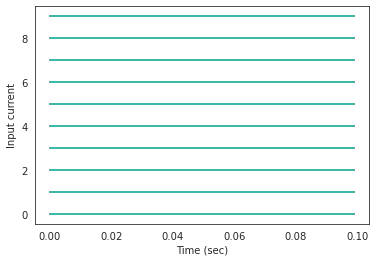

In [84]:
stim_length_sec = 0.1
dt_sec = 0.001
n_time_bins = int(np.floor(stim_length_sec / dt_sec))

input_current, list_mean = sweep_steps(amplitudes=np.arange(10), n_trials=10, dt_sec=dt_sec, stim_length_sec=stim_length_sec, sig=0, debug_plot=True)

In [85]:
assert(input_current.shape[0]==1)
assert(input_current.shape[1]==n_time_bins)

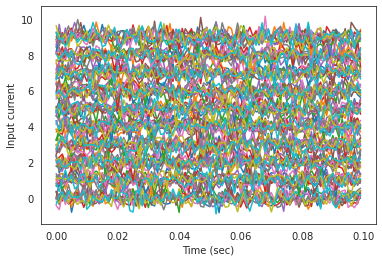

In [86]:
stim_length_sec = 0.1
dt_sec = 0.001
n_time_bins = int(np.floor(stim_length_sec / dt_sec))

input_current, list_mean = sweep_steps(amplitudes=np.arange(10), n_trials=10, dt_sec=dt_sec, stim_length_sec=stim_length_sec, sig=0.1, debug_plot=True)

### 2. Oscillations (amplitude)

n time bins:1000
Period T:0.1 sec


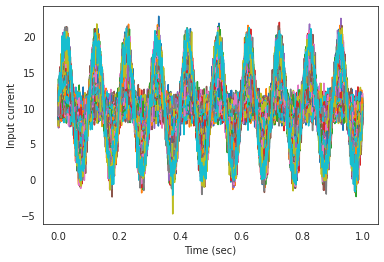

In [87]:
input_current, list_ampl = sweep_amplitude_oscillations(amplitudes=np.arange(10), n_trials=10, offset=10, f=10, fs=1000, target_snr_db=20, debug_plot=True, add_noise=True)

### 3. Oscillation (frequency)

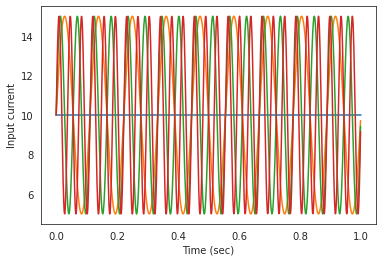

In [88]:
input_current, list_ampl = sweep_frequency_oscillations(frequencies=np.arange(30,step=9), n_trials=1, offset=10, amplitude=5, fs=1000, target_snr_db=20, debug_plot=True, add_noise=False)

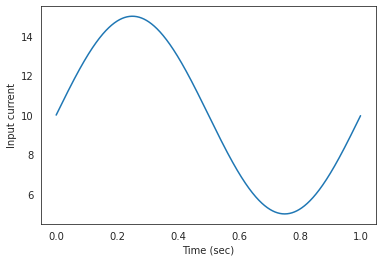

In [92]:
input_current_1, list_ampl = sweep_frequency_oscillations(frequencies=[1], n_trials=1, offset=10, amplitude=5, fs=1000, target_snr_db=20, debug_plot=True, add_noise=False)

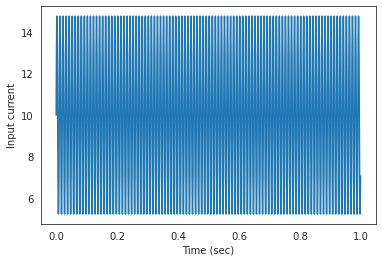

In [104]:
input_current_10, list_ampl = sweep_frequency_oscillations(frequencies=[100], n_trials=1, offset=10, amplitude=5, fs=1000, target_snr_db=20, debug_plot=True, add_noise=False)

In [105]:
from torch.nn.functional import conv1d


torch_c = conv1d(input_current_1, input_current_10, padding=len(input_current_1[0,:,0]))

In [106]:
a = np.convolve(input_current_1[0,:,0], input_current_10[0,:,0])

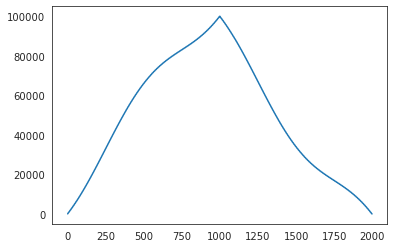

In [107]:
plt.plot(a)

In [109]:
a = input_current_1 + input_current_10

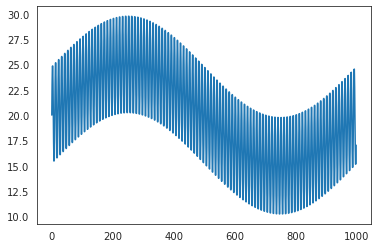

In [111]:
plt.plot(a[0,:,0])